# Binary Classification In Deep Learning

### Step1. Class label을 0과 1로 할당할 것
### Step2. Metric과 Loss function을 수정하자.
  - Classification은 0 또는 1의 값이 output이기에 기존 MAE로 산정 시, 오차가 크게 벌어질 수 있음
     - 거리개념인 MAE는 이제 적합하지 않음 (0이 True인데, 1로 predict시 오차가 크게 "jump"하여 올바르게 학습하기가 어려움)
     - 새로운 척도가 필요하다: Cross-Entropy
     
  - MAE가 output간의 거리라면, Cross-Entropy는 Label을 1이라고하는 확률, 그 확률간의 거리를 의미한다.
  - Class label을 1이라고 하면, 확률을 1로 Predict시 Loss가 가장 낮으며, 1에서 멀어질수록 Loss가 커지는 성질을 반영한 척도: Cross Entropy
  
### Step3. Cross Entropy를 위한 확률을 생성하는 방법: Activation Sigmoid
  - output이 sigmoid 통과 후, [0,0.5]면 Class label:0 // [0.5,1]이면 Class label: 1
  - 여기서 사용하는 0.5의 Threshold는 변경가능! (default: 0.5)
  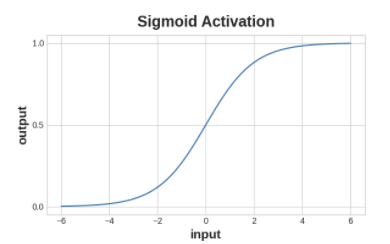

### 별첨 About Cross Entropy
 - binary_crossentropy: Binary Classification에서 활용
 - categorical_crossentropy: Multilabel Classfication에서 Label이 one-hot-encoding된 형태 [0,1,0], [1,0,0]
 - sparse_categorical_crossentropy: Multilabel Classfication에서 Label이 one-hot-encoding이 안된 형태 [1, 5, 3, 4]

# 실전연습

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

##### 전처리

In [15]:
hotel = pd.read_csv('./data/hotel.csv')

# X랑 y를 pop으로 하니 간단하게 X,y분류가 가능
X = hotel.copy()
y = X.pop('is_canceled')

# 각 String type을 숫자로 label encoding
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

# numeric 및 categorical type column 분류
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

# 각 특성에 따라 Transformation
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# Train test분리 후 정규화
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

##### modeling
 - binary_accuracy = accuracy
 - 기존 ['accuracy']라고 넣으면, 자동으로 binary_accruacy로 변환된다함.


출처: https://www.python2.net/questions-1150260.htm

<AxesSubplot:title={'center':'Accuracy'}>

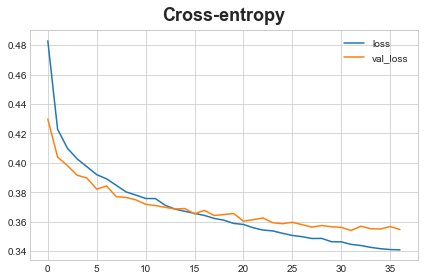

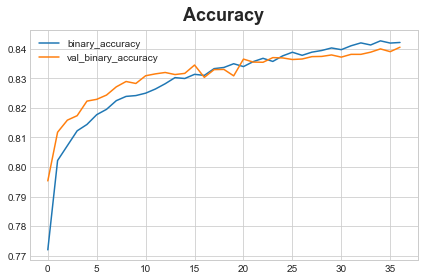

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

# architecture
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    
    layers.Dense(1, activation='sigmoid')
])

# compile
model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer='adam')

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


# train
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0
)

# make plot
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### 결론
 - loss가 줄어들수록 accuracy는 증가! CrossEntropy는 classification에 있어 좋은 척도다.